# Human exploration bias

This notebook explore the human bias in exploring large loss solution.

To do so, we calculate the following:
* the distribution of a random explorer testing a large loss (and three large losses)
* the distribution of humans testing large losses
* the change in likelihood in humans over the 3 / 6 trails


In [145]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
# add dqn sub folder to python path
import sys
sys.path.append('dqn')

In [147]:
import pandas as pd
import numpy as np
import os

import yaml
import json
import os


import torch as th
from dqn.environment_vect import Reward_Network
from dqn.config_type import Config

In [148]:
experiment_type = 'reward-network-iii-exp-v2'

moves_df = pd.read_csv(os.path.join('../data/exp_processed/moves.csv'))

networks_file = '../data/networks_solutions_models/solution_exp__valid_networks.json'

# Load the networks
with open(networks_file) as f:
    networks_exp = json.load(f)

config_file = '../algorithm/params/seed_0.yml'
with open(config_file) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config = Config(**config)

In [149]:
moves_df.columns

Index(['session_id', 'session_name', 'replication_idx', 'condition',
       'generation', 'within_generation_idx', 'started_at', 'time_spend',
       'expired', 'replaced', 'ai_player', 'simulated_subject', 'advisor',
       'player_score', 'move_idx', 'source_num', 'target_num', 'reward',
       'level', 'correct_repeat', 'myopic', 'optimal', 'large_loss_taken',
       'trial_id', 'trial_type', 'network_id', 'solution_total_score'],
      dtype='object')

In [150]:
moves_df['session_trial_id'] = moves_df['session_id'].astype(str) + '_' + moves_df['trial_id'].astype(str)

session_trial_id = moves_df['session_trial_id'].unique()
session_trial_idx = {session_trial_id[i]: i for i in range(len(session_trial_id))}

filter_columns = [
    'session_trial_id', 'session_id', 'session_name', 'replication_idx', 'condition',
       'generation', 'within_generation_idx', 'ai_player', 'move_idx', 'source_num', 'target_num', 'reward',
       'network_id', 'trial_id', 'trial_type'
]
moves_df = moves_df[filter_columns]


In [151]:
human_moves = th.full((len(session_trial_id), 10), -1, dtype=th.int64)
network_ids = []

for _, row in moves_df.iterrows():
    idx = session_trial_idx[row['session_trial_id']]
    human_moves[idx, row['move_idx']] = row['target_num']
    if row['move_idx'] == 0:
        network_ids.append(row['network_id'])

In [152]:
networks_keyed = {network['network_id']: network for network in networks_exp}
networks_reorganized = [networks_keyed[network_id] for network_id in network_ids]

In [153]:
human_moves.shape

torch.Size([19568, 10])

In [154]:
experiment_type = 'reward-network-iii-exp-v2'

DEVICE = th.device("cuda" if th.cuda.is_available() else "cpu")

env_random = Reward_Network(networks_reorganized, network_batch=None, config=config, device=DEVICE)

env_random.reset()
obs_random = env_random.observe()

random_rewards = []
random_moves = [env_random.starting_nodes]

for round_num in range(config.n_rounds):
    random_action = th.multinomial(obs_random["mask"].type(th.float), 1)[:, 0]
    obs_random, reward_random, level_random, is_done_random = env_random.step(random_action, normalize_reward=False)
    random_rewards.append(reward_random)
    random_moves.append(random_action)
random_rewards = th.stack(random_rewards, dim=1)
random_moves = th.stack(random_moves, dim=1)

environment_vect reward_norm_map tensor([ 0.0000, -1.0000, -0.7778, -0.3333,  0.1111,  1.0000])


/Users/brinkmann/repros/reward-network-iii/algorithm/dqn/environment_vect.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.reward_map[prova_values] = torch.tensor(prova_keys, dtype=torch.long)


In [155]:
moves_random_df = moves_df.copy()
moves_random_df['random_counterfactual'] = True


for idx, row in moves_random_df.iterrows():
    session_idx = session_trial_idx[row['session_trial_id']]
    move_idx = row['move_idx']
    moves_random_df.at[idx, 'source_num'] = random_moves[session_idx, move_idx].item()
    moves_random_df.at[idx, 'target_num'] = random_moves[session_idx, move_idx+1].item()
    moves_random_df.at[idx, 'reward'] = random_rewards[session_idx, move_idx].item()

In [156]:
moves_df['random_counterfactual'] = False
joined_df = pd.concat([moves_df, moves_random_df])
joined_df = joined_df.sort_values(by=['session_trial_id', 'random_counterfactual', 'move_idx'])
joined_df = joined_df.reset_index(drop=True)

joined_df['is_loss'] = joined_df['reward'] < 0

In [157]:
joined_df['total_score'] = joined_df.groupby(['session_trial_id', 'random_counterfactual'])['reward'].transform('sum')
joined_df['n_loss'] = joined_df.groupby(['session_trial_id', 'random_counterfactual'])['is_loss'].transform('sum')

In [158]:
# Ensure is_loss is binary (0/1)
is_loss = joined_df['is_loss'].astype(int)

# Identify where a new run starts (either is_loss == 0 or a break in sequence)
run_id = (
    (is_loss == 0) |
    (is_loss != is_loss.shift()) |
    (joined_df[['session_trial_id', 'random_counterfactual']]
     != joined_df[['session_trial_id', 'random_counterfactual']].shift()).any(axis=1)
).cumsum()

# Compute run lengths of consecutive losses
run_length = (
    joined_df
    .assign(run_id=run_id)
    .groupby(['session_trial_id', 'random_counterfactual', 'run_id'])['is_loss']
    .sum()
)

# Get maximum consecutive losses per group
max_consecutive_loss = (
    run_length
    .groupby(['session_trial_id', 'random_counterfactual'])
    .max()
)

# Broadcast back to the original dataframe
joined_df['max_loss_consecutive'] = joined_df.set_index(
    ['session_trial_id', 'random_counterfactual']
).index.map(max_consecutive_loss)


In [174]:
agg_df = joined_df.groupby(['session_trial_id', 'random_counterfactual', 'trial_id', 'generation', 'ai_player', 'trial_type']).agg({
    'max_loss_consecutive': 'mean',
    'total_score': 'mean',
    'n_loss': 'mean'
}).reset_index()

agg_df['is_high_scoring'] = agg_df['total_score'] > 2000


In [160]:
agg_df.head()

,session_trial_id,random_counterfactual,trial_id,generation,ai_player,trial_type,max_loss_consecutive,total_score,n_loss
0,65d32e25dd6859254f5c592a_0,False,0,0,True,individual,3.0,2650.0,3.0
1,65d32e25dd6859254f5c592a_0,True,0,0,True,individual,3.0,1300.0,4.0
2,65d32e25dd6859254f5c592a_1,False,1,0,True,individual,3.0,2650.0,3.0
3,65d32e25dd6859254f5c592a_1,True,1,0,True,individual,2.0,1200.0,4.0
4,65d32e25dd6859254f5c592a_2,False,2,0,True,individual,3.0,2650.0,3.0


In [161]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_ordinal_probs_with_ci_bar(df, x, hue, ax=None, n_boot=1000, ci=95):

    ks = sorted(df[x].dropna().unique())

    # long-form: one row per (original row, k) with indicator I[x==k]
    long = pd.concat(
        [
            df[[hue, x]].assign(k=k, ind=(df[x] == k).astype(int))
            for k in ks
        ],
        ignore_index=True
    )

    if ax is None:
        _, ax = plt.subplots()

    sns.barplot(
        data=long,
        x="k",
        y="ind",
        hue=hue,
        order=ks,
        estimator=np.mean,
        errorbar=("ci", ci),
        n_boot=n_boot,
        dodge=True,
        ax=ax
    )

    ax.set_xlabel(x)
    ax.set_ylabel(f"P({x}=k | {hue})")
    return ax



/Users/brinkmann/repros/reward-network-iii/.venv/lib/python3.13/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/brinkmann/repros/reward-network-iii/.venv/lib/python3.13/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


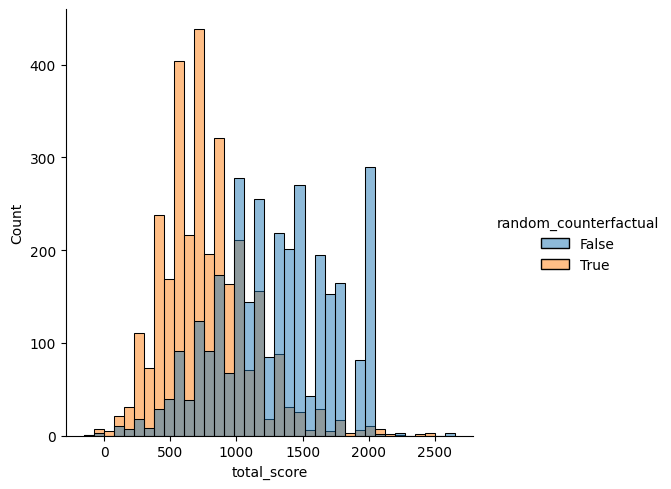

In [179]:
not_ai = ~agg_df['ai_player']
i_trail = agg_df['trial_type'] == 'individual'

df_i = agg_df[i_trail & not_ai]

sns.displot(data=df_i, x='total_score', hue='random_counterfactual', kind='hist')


/Users/brinkmann/repros/reward-network-iii/.venv/lib/python3.13/site-packages/seaborn/categorical.py:1281: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


<Axes: xlabel='random_counterfactual', ylabel='is_high_scoring'>

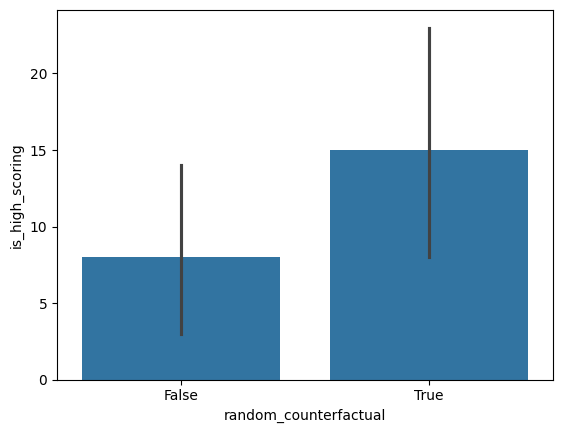

In [178]:
not_ai = ~agg_df['ai_player']
i_trail = agg_df['trial_type'] == 'individual'

df_i = agg_df[i_trail & not_ai]

sns.barplot(data=df_i, y='is_high_scoring', x='random_counterfactual', estimator=np.sum)

In [163]:
len(agg_df)

39136

/Users/brinkmann/repros/reward-network-iii/.venv/lib/python3.13/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/brinkmann/repros/reward-network-iii/.venv/lib/python3.13/site-packages/seaborn/categorical.py:1281: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)
/Users/brinkmann/repros/reward-network-iii/.venv/lib/python3.13/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a lengt

<Axes: xlabel='n_loss', ylabel='P(n_loss=k | random_counterfactual)'>

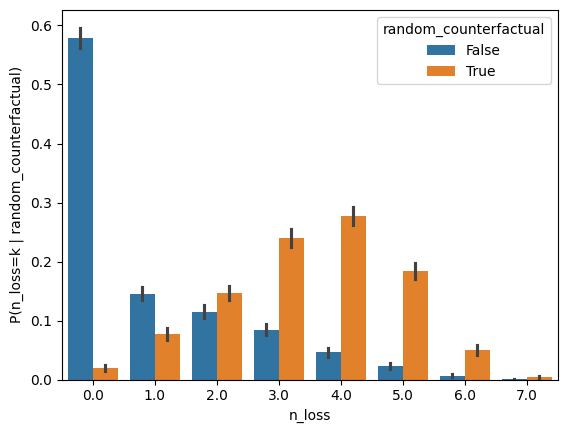

In [164]:
not_ai = ~agg_df['ai_player']
i_trail = agg_df['trial_type'] == 'individual'

df_i = agg_df[i_trail & not_ai]

plot_ordinal_probs_with_ci_bar(df_i, x='n_loss', hue='random_counterfactual')

/Users/brinkmann/repros/reward-network-iii/.venv/lib/python3.13/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/brinkmann/repros/reward-network-iii/.venv/lib/python3.13/site-packages/seaborn/categorical.py:1281: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)
/Users/brinkmann/repros/reward-network-iii/.venv/lib/python3.13/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a lengt

<Axes: xlabel='max_loss_consecutive', ylabel='P(max_loss_consecutive=k | random_counterfactual)'>

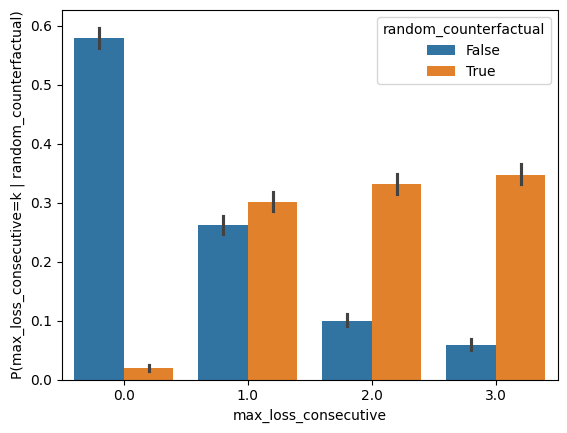

In [165]:
not_ai = ~agg_df['ai_player']
i_trail = agg_df['trial_type'] == 'individual'

df_i = agg_df[i_trail & not_ai]

plot_ordinal_probs_with_ci_bar(df_i, x='max_loss_consecutive', hue='random_counterfactual')

/Users/brinkmann/repros/reward-network-iii/.venv/lib/python3.13/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/brinkmann/repros/reward-network-iii/.venv/lib/python3.13/site-packages/seaborn/categorical.py:1281: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)
/Users/brinkmann/repros/reward-network-iii/.venv/lib/python3.13/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a lengt

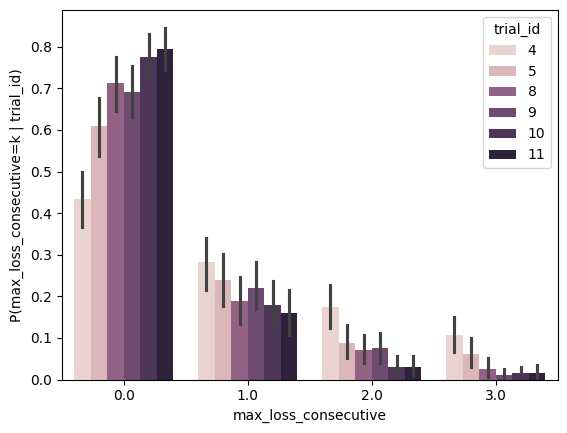

In [ ]:
not_ai = ~agg_df['ai_player']
i_trail = agg_df['trial_type'] == 'individual'
i_non_random = agg_df['random_counterfactual'] == False
first_gen = agg_df['generation'] == 0

df_i = agg_df[i_trail & not_ai & i_non_random & first_gen]

plot_ordinal_probs_with_ci_bar(
    df_i,
    x='max_loss_consecutive',
    hue='trial_id'
)

/Users/brinkmann/repros/reward-network-iii/.venv/lib/python3.13/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/brinkmann/repros/reward-network-iii/.venv/lib/python3.13/site-packages/seaborn/categorical.py:1281: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)
/Users/brinkmann/repros/reward-network-iii/.venv/lib/python3.13/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a lengt

<Axes: xlabel='max_loss_consecutive', ylabel='P(max_loss_consecutive=k | generation)'>

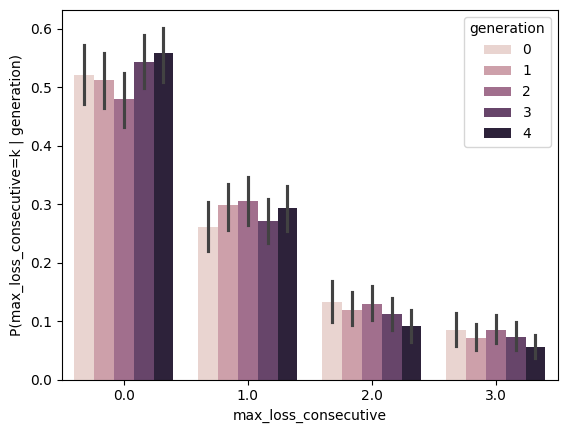

In [173]:
not_ai = ~agg_df['ai_player']
i_trail = agg_df['trial_type'] == 'individual'
i_non_random = agg_df['random_counterfactual'] == False

# First two trails
first_2_trails = agg_df['trial_id'].isin([4, 5])

df_i = agg_df[i_trail & not_ai & i_non_random & first_2_trails]


plot_ordinal_probs_with_ci_bar(
    df_i,
    x='max_loss_consecutive',
    hue='generation'
)